In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import yaml
import os
import matplotlib.pyplot as plt

with open('../configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

T = config['diffusion']['T']
beta_start = config['diffusion']['beta_start']
beta_end = config['diffusion']['beta_end']
batch_size = 64
learning_rate = 1e-4

epochs = 30
checkpoint_dir = '../checkpoints' # salvo i pesi del modello in questa directory
os.makedirs(checkpoint_dir, exist_ok=True)

In [23]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.embedding = nn.Sequential(
            nn.Linear(dim, dim),
            nn.SiLU(),
            nn.Linear(dim, dim)
        )
    
    def get_sinusoidal_embedding(self, t):
        t = t.to(dtype=torch.float32) 
        half_dim = self.dim // 2
        freqs = torch.arange(half_dim, dtype=torch.float32, device=t.device)
        freqs = 10000 ** (-freqs / half_dim)
        angles = t[:, None] * freqs[None, :]
        emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)
        return emb
    
    def forward(self, t):
        emb = self.get_sinusoidal_embedding(t)
        emb = self.embedding(emb)
        return emb


In [24]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
        )
    
    def forward(self, x):
        return self.conv(x)

In [25]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=64, time_dim=128):
        super().__init__()
        self.time_dim = time_dim
        self.time_emb = TimeEmbedding(time_dim)
        self.enc1 = ConvBlock(in_channels, base_channels)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(base_channels, base_channels * 2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(base_channels * 2, base_channels * 4)
        self.bottleneck = ConvBlock(base_channels * 4, base_channels * 4)
        self.up1 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(base_channels * 4, base_channels * 2)
        self.up2 = nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(base_channels * 2, base_channels)
        self.out = nn.Conv2d(base_channels, out_channels, kernel_size=3, padding=1)
        self.time_proj1 = nn.Linear(time_dim, base_channels)
        self.time_proj2 = nn.Linear(time_dim, base_channels * 2)
        self.time_proj3 = nn.Linear(time_dim, base_channels * 4)
    
    def forward(self, x, t):
        t_emb = self.time_emb(t)
        e1 = self.enc1(x) + self.time_proj1(t_emb)[:, :, None, None]
        d1 = self.pool1(e1)
        e2 = self.enc2(d1) + self.time_proj2(t_emb)[:, :, None, None]
        d2 = self.pool2(e2)
        e3 = self.enc3(d2) + self.time_proj3(t_emb)[:, :, None, None]
        b = self.bottleneck(e3)
        u1 = self.up1(b)
        u1 = torch.cat([u1, e2], dim=1)
        d1 = self.dec1(u1)
        u2 = self.up2(d1)
        u2 = torch.cat([u2, e1], dim=1)
        d2 = self.dec2(u2)
        out = self.out(d2)
        return out

In [26]:
class NoiseScheduler:
    def __init__(self, T, beta_start, beta_end):
        self.T = T
        self.beta_start = beta_start
        self.beta_end = beta_end
        
        # Calcola beta, alpha e alpha_bar
        self.beta = torch.linspace(beta_start, beta_end, T)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
    
    def add_noise(self, x_0, t, noise):
        # Aggiunge rumore all'immagine x_0 al timestep t
        self.alpha_bar = self.alpha_bar.to(t.device)  # Sposto self.alpha_bar sulla stessa device di t
        alpha_bar_t = self.alpha_bar[t].reshape(-1, 1, 1, 1)
        return torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise

In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [28]:
# Training Loop
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') # determino il dispositivo su cui eseguire il training (GPU integrata apple silicon)

# Inizializzo i modelli
scheduler = NoiseScheduler(T, beta_start, beta_end)
unet = UNet().to(device) 
optimizer = optim.Adam(unet.parameters(), lr=learning_rate) # ottimizzatore per aggiornare i pesi della U-Net durante il training
criterion = nn.MSELoss() # mi permette di misurare 

# Lista per salvare la loss media di ogni epoca
losses = []

# Training
for epoch in range(epochs):
    unet.train()
    total_loss = 0
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        batch_size = images.shape[0] # [64,1,28,28] --> 64 (batch_size)
        
        # Campiona timestep casuali
        t = torch.randint(0, T, (batch_size,), device=device)
        
        # Genera rumore e immagine rumorosa
        noise = torch.randn_like(images)
        noisy_images = scheduler.add_noise(images, t, noise)
        
        # Previsione del rumore
        predicted_noise = unet(noisy_images, t)
        
        # Calcola la loss
        loss = criterion(predicted_noise, noise)
        total_loss += loss.item() # accumulo la loss di ogni batch
        
        # Ottimizzazione
        optimizer.zero_grad() # azzero i gradienti accumulati nei batch precedenti
        loss.backward()
        optimizer.step() # aggiorno i pesi della U-net 
        
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    # Calcolo e salvo la loss media
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}] Average Loss: {avg_loss:.4f}")
    
    # Salvo il modello
    torch.save(unet.state_dict(), os.path.join(checkpoint_dir, f'unet_epoch_{epoch+1}.pth'))

Epoch [1/30], Step [0/938], Loss: 1.1071
Epoch [1/30], Step [100/938], Loss: 0.1029
Epoch [1/30], Step [200/938], Loss: 0.0606
Epoch [1/30], Step [300/938], Loss: 0.0583
Epoch [1/30], Step [400/938], Loss: 0.0356
Epoch [1/30], Step [500/938], Loss: 0.0475
Epoch [1/30], Step [600/938], Loss: 0.0568
Epoch [1/30], Step [700/938], Loss: 0.0517
Epoch [1/30], Step [800/938], Loss: 0.0388
Epoch [1/30], Step [900/938], Loss: 0.0281
Epoch [1/30] Average Loss: 0.0644
Epoch [2/30], Step [0/938], Loss: 0.0341
Epoch [2/30], Step [100/938], Loss: 0.0280
Epoch [2/30], Step [200/938], Loss: 0.0311
Epoch [2/30], Step [300/938], Loss: 0.0452
Epoch [2/30], Step [400/938], Loss: 0.0315
Epoch [2/30], Step [500/938], Loss: 0.0297
Epoch [2/30], Step [600/938], Loss: 0.0308
Epoch [2/30], Step [700/938], Loss: 0.0296
Epoch [2/30], Step [800/938], Loss: 0.0273
Epoch [2/30], Step [900/938], Loss: 0.0253
Epoch [2/30] Average Loss: 0.0336
Epoch [3/30], Step [0/938], Loss: 0.0266
Epoch [3/30], Step [100/938], Loss:

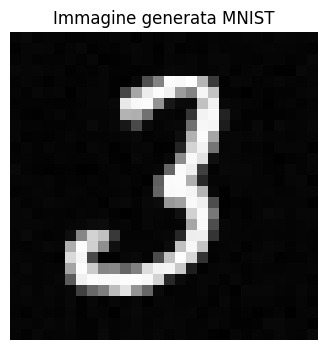

In [37]:
unet.eval()

with torch.no_grad(): # riduco l'utilizzo di memoria
    # Campiono un'immagine di rumore casuale
    x_t = torch.randn(1, 1, 28, 28).to(device)
    
    # Eseguo il processo inverso per generare l'immagine
    for i in range(T-1, -1, -1):
        t = torch.full((1,), i, dtype=torch.long, device=device) # creo un tensore casuale
        
        # Predico il rumore
        predicted_noise = unet(x_t, t)
        
        # Calcola i coefficienti di diffusione inversa
        alpha_t = scheduler.alpha[i].to(device)
        alpha_bar_t = scheduler.alpha_bar[i].to(device)
        
        if i > 0:
            noise = torch.randn_like(x_t)
            beta_t = scheduler.beta[i].to(device)
        else:
            noise = torch.zeros_like(x_t)
            beta_t = torch.tensor(0.0).to(device)
            
        # Formula di campionamento inverso DDPM
        x_t = (1 / torch.sqrt(alpha_t)) * (x_t - (beta_t / torch.sqrt(1 - alpha_bar_t)) * predicted_noise) + torch.sqrt(beta_t) * noise
    
    # Denormalizza l'immagine (da [-0.5, 0.5] a [0, 1])
    generated_image = (x_t.squeeze().cpu() * 0.5 + 0.5).numpy()
    
    # Mostro l'immagine generata
    plt.figure(figsize=(4, 4))
    plt.imshow(generated_image, cmap='gray')
    plt.axis('off')
    plt.title("Immagine generata MNIST")
    plt.show()